# Object Detection for hand-writing using CVTK (AML Package for Computer Vision)

### Overview

Object Detection is one of the main problems in Computer Vision. Traditionally, this required expert knowledge to identify and implement so called “features” that highlight the position of objects in the image. Starting in 2012 with the famous AlexNet paper, Deep Neural Networks are used to automatically find these features.

This notebook shows how the Azure Machine Learning Package for Computer Vision can be used to train, evaluate, and deploy a Faster R-CNN object detection model. The Computer Vision Toolkit (CVTK) makes it easy to perform all these steps, and internally uses Tensorflow's implementation of Faster R-CNN. Faster R-CNN was shown to produce state-of-the-art results for Pascal VOC, one of the main object detection challenges in the field. For more information see the [Tensorflow object detection website](https://github.com/tensorflow/models/tree/master/research/object_detection).

### Image Annotation

Manually annotated object locations are required to train and evaluate an object detector. One excellent UI to help drawing bounding boxes is [VOTT](https://github.com/Microsoft/VoTT) which has been pre-installed in Microsoft DLVM. VOTT writes an xml-file per image in Pascal-VOC format, which can be read into CVTK (see below). 


### Example Dataset
For this demo, a dataset of goverment lease is provided, consisting of 182 images, and 2 classes (e.g. signature and others). These images can be see in the folder "./lease_data". For each jpg image in the folder "./lease_data/JPEGImages", an annotation xml-file with similar name exists in  "./lease_data/Annotations". These images and bounding box annotations will be loaded in the next section.

## Training and Evaluation

### Step 1: Dataset creation

Create a CVTK dataset object which consists of a set of images, with their respective bounding box annotations. In the example below, we will read in the refrigerator images which are provided in the "./lease_data" folder. Note that only JPEG images are supported.

In [1]:
import os, time
from cvtk.core import Context, ObjectDetectionDataset, TFFasterRCNN
from cvtk.utils import detection_utils

%matplotlib inline

C:\Users\tz2018\AppData\local\AmlWorkbench\Python\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
## Specify data and model directory and give scoring image path
image_folder = "<input image folder including subfolders of jpg and xml>" # training data from VOTT labeling tool
model_dir = "<saved model directory>" # dir for saved training models
image_path = "<test image path>" # scoring image path
result_path = "<results path>" # dir for saving images with detection boxes and placeholder text

In [3]:
data_train = ObjectDetectionDataset.create_from_dir_pascal_voc(dataset_name='training_dataset', data_dir=image_folder)

C:\Users\tz2018\AppData\local\AmlWorkbench\Python\lib\site-packages\cvtk\libs\object_detection\utils\dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


### Step 2: Define a model

Various parameters can be provided when defining a model. The meaning of these parameters, as well as the parameters used for training (see next section) can be found in either CVTK's API docs, or on the [Tensorflow object detection website](https://github.com/tensorflow/models/tree/master/research/object_detection). 

In [4]:
score_threshold = 0.0       # Threshold on the detection score, use to discard lower-confidence detections.
max_total_detections = 300  # Maximum number of detections. A high value will slow down training but might increase accuracy.
my_detector = TFFasterRCNN(labels=data_train.labels, 
                           score_threshold=score_threshold, 
                           max_total_detections=max_total_detections)

In [5]:
print ('the labels in the training dataset are {}'.format(data_train.labels))

the labels in the training dataset are [<Label(name = signature)>, <Label(name = others)>]


### Step 3: Train the model

We can now train our object detector. This requires a GPU. The training time is around 5 mins for 350 training steps. 

Two key parameters for training are number of steps and learning rates.

The argument num_steps can be used to specify the number of minibatches used to train the model. Since the minibatch size is set to 1 in this release, it equals the number of images considered during training.
In this application, we should set num_steps to be 30 times the number of images in the training set. (Suppose 30 epoches here).


The default minibatch size is equal to 1. Learning rates can be set using the following arguments:
- initial_learning_rate: the initial learning rate.
- learning_rate1: the learning rate for steps since step1. For example, learning_rate1=0.0003 (default) and step1=0  (default) means that the learning rate is 0.0003 from step 0. This values overrides initial_learning_rate if step1=0.
- learning_rate2: the learning rate for steps since step2. For instance, learning_rate1=0.00003 (default) and step2=900000 (default) means that the learning rate is 0.00003 from step 900,000.
- learning_rate3: the learning rate for steps since step3. For example, learning_rate1=0.000003  (default) and step2=1200000  (default) means that the learning rate is 0.000003 from step 1,200,000.

In [6]:
num_steps = None # when the num_steps = None, it is equal to the len(data_train.images)*30 with default 30 epoches
learning_rate = 0.001 # learning rate
step1 = 200 # used to update learning rate. From 0 to step1: initial_learning rate. Step1 to step2 (900000): learning_rate1

start_train = time.time()
my_detector.train(dataset=data_train, num_steps=num_steps, 
                  initial_learning_rate=learning_rate,
                  step1=step1,
                  learning_rate1=learning_rate)
end_train = time.time()
print("the total training time is {}".format(end_train-start_train))

downloading checkpoint file to C:\Users\tz2018\Downloads\cvp-1.0.0b2-release\cvp-1.0.0b2-release\cvp_project\detection\notebook\data\models\detection\faster_rcnn_resnet50_coco_2018_01_28\model.ckpt.index


C:\Users\tz2018\AppData\local\AmlWorkbench\Python\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


the total training time is 4080.0466601848602


TensorBoard can be used to visualize the training progress. TensorBoard events are located in the folder specified by the model object's train_dir attribute. For instance, copy the following printout to a command line to view TensorBoard. 

In [23]:
print("tensorboard –-logdir={}".format(my_detector.train_dir))

tensorboard –-logdir=C:\Users\tz2018\Downloads\cvp-1.0.0b2-release\cvp-1.0.0b2-release\cvp_project\detection\notebook\temp\2018_04_16_16_49_21_faster_rcnn_resnet50\models\train


Then copy the URL from the command window to a web browser to view it. 

## Scoring

### Step 4: Save the model

In [7]:
frozen_model_path, label_map_path = my_detector.save(model_dir)
print("Frozen model written to path: " + frozen_model_path)
print("Labels written to path: " + label_map_path)

Converted 275 variables to const ops.
Frozen model written to path: D:\Projects\EY\models\frozen_inference_graph.pb
Labels written to path: D:\Projects\EY\models\label_map.pbtxt


### Step 5: Score an image

In [8]:
dectections_dict = detection_utils.score(frozen_model_path, image_path)

Below we print out the detected objects with scores above 0.5, including labels, scores, and coordinates. You can change the change the score lower bound to some other values, such as 0.6, 0.7...
The detected objects are listed in a decending-score order.

In [9]:
look_up = dict((v,k) for k,v in my_detector.class_map.items())
n_obj = 0
detect_index = [] # record the detection index in the detections_dict
for i in range(dectections_dict['num_detections']):
    if dectections_dict['detection_scores'][i] > 0.5:
        detect_index.append(i)
        n_obj += 1
        print("Object {}: label={:11}, score={:.2f}, location=(top: {:.2f}, left: {:.2f}, bottom: {:.2f}, right: {:.2f})".format(
            i, look_up[dectections_dict['detection_classes'][i]], 
            dectections_dict['detection_scores'][i], 
            dectections_dict['detection_boxes'][i][0],
            dectections_dict['detection_boxes'][i][1], 
            dectections_dict['detection_boxes'][i][2],
            dectections_dict['detection_boxes'][i][3]))    
        
print("\nFound {} objects in image {}.".format(n_obj, image_path))           

Object 0: label=others     , score=1.00, location=(top: 0.06, left: 0.73, bottom: 0.10, right: 0.86)
Object 1: label=others     , score=0.99, location=(top: 0.82, left: 0.46, bottom: 0.85, right: 0.67)
Object 2: label=signature  , score=0.99, location=(top: 0.88, left: 0.11, bottom: 0.92, right: 0.39)
Object 3: label=signature  , score=0.99, location=(top: 0.69, left: 0.13, bottom: 0.73, right: 0.24)
Object 4: label=others     , score=0.99, location=(top: 0.83, left: 0.73, bottom: 0.88, right: 0.83)
Object 5: label=others     , score=0.98, location=(top: 0.77, left: 0.48, bottom: 0.81, right: 0.59)
Object 6: label=signature  , score=0.97, location=(top: 0.74, left: 0.08, bottom: 0.81, right: 0.25)
Object 7: label=others     , score=0.92, location=(top: 0.82, left: 0.03, bottom: 0.86, right: 0.34)

Found 8 objects in image ../test_data/test3.jpg.


### Step 6: Visualize the scored image

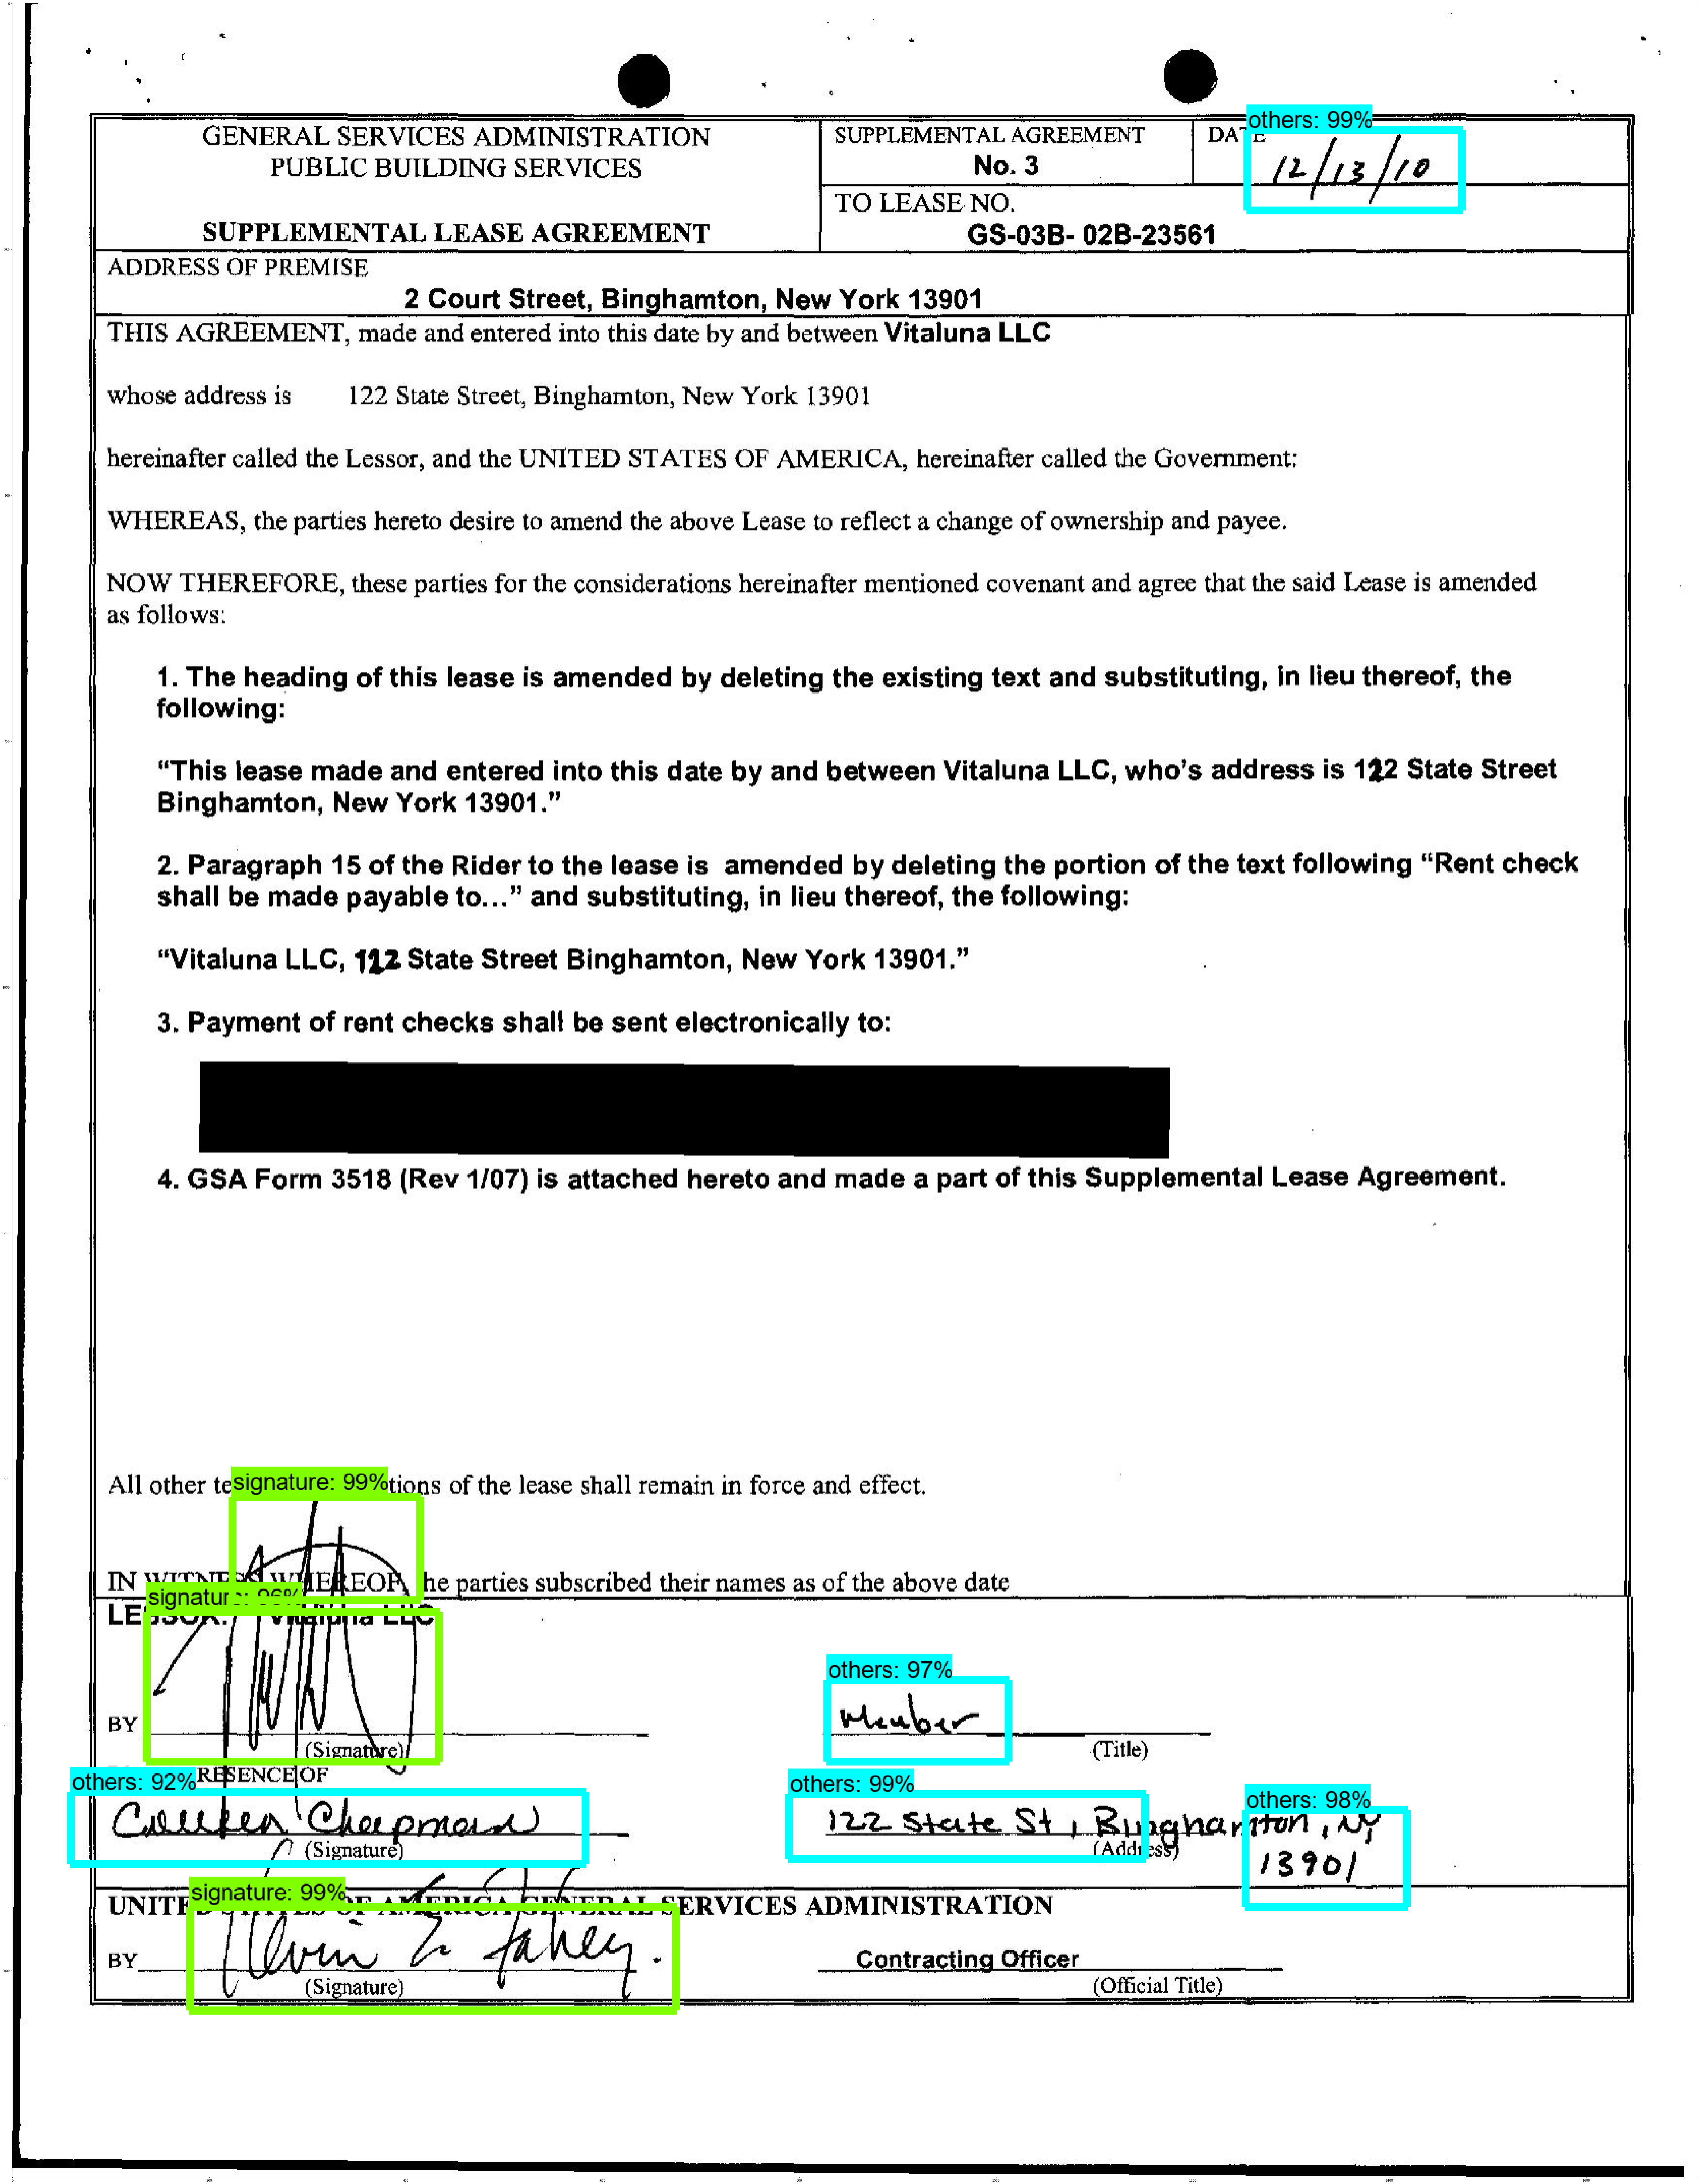

In [27]:
image_size=(100, 190)
save_scoring_path = os.path.join(result_path, image_path.split('/')[-1])
_ = detection_utils.visualize(image_path, dectections_dict, label_map_path, path_save=save_scoring_path, image_size=image_size)

## Step 7: Computer Vision API for handwriting OCR

### helper function

In [11]:
def pass2CV(img_array):
    import requests
    
    print ('pass image to computer vision API ......')
    image_data = cv2.imencode('.jpg', img_array)[1].tostring() # convert image array to image bytes
    
    vision_base_url = "https://westus2.api.cognitive.microsoft.com/vision/v1.0/"

    text_recognition_url = vision_base_url + "RecognizeText"

    # change to your Computer Vision API subscription key
    headers  = {'Ocp-Apim-Subscription-Key': subscription key,
               "Content-Type": "application/octet-stream"}
    params   = {'handwriting' : True}

    response = requests.post(text_recognition_url, headers=headers, params=params, data=image_data)
    response.raise_for_status()

    operation_url = response.headers["Operation-Location"]

    analysis = {}
    while not "recognitionResult" in analysis:
        response_final = requests.get(response.headers["Operation-Location"], headers=headers)
        analysis       = response_final.json()
        time.sleep(1)

    polygons = [(line["boundingBox"], line["text"]) for line in analysis["recognitionResult"]["lines"]]
    
    return polygons


In [12]:
def textReplace(text, top, left, bottom, right):
    # Create a blank image
    import numpy as np
    img = np.ones((bottom-top,right-left,3), np.uint8)*255 # build white background

    if min(img.shape[0:2])>150:
        fontScale  = int(min(img.shape[0:2])/150)
    else:
        fontScale = 1
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0,0,0) # font color is black
    lineType = 2

    # setup text
    font = cv2.FONT_HERSHEY_SIMPLEX

    # get boundary of this text
    textsize = cv2.getTextSize(text, font, 1, 2)[0]

    # get coords based on boundary to center the text
    textX = (img.shape[1] - textsize[0]) / 2
    textY = (img.shape[0] + textsize[1]) / 2

    cv2.putText(img,text, (int(textX), int(textY)), font, fontScale, fontColor, lineType)
    return img

In [18]:
import cv2
from random import randint

img = cv2.imread(image_path)
height, width = cv2.imread(image_path).shape[0:2]
print (height, width)

match = {}

for i in detect_index:
    top, left, bottom, right = dectections_dict['detection_boxes'][i][0],dectections_dict['detection_boxes'][i][1], \
    dectections_dict['detection_boxes'][i][2],dectections_dict['detection_boxes'][i][3]

    top, left, bottom, right = int(top*height), int(left*width), int(bottom*height), int(right*width)
    
    text = str(8) + str(randint(100, 999)) + str(8)
    img_cropped = img[top:bottom, left:right,:] # crop each handwriting box
    polygons = pass2CV(img_cropped) # pass each cropped image to computer vision API
    
    # replace handwriting box with machine-text placeholder
    img[top:bottom, left:right,:]= textReplace(text, top, left, bottom, right)  
    
    tmp = []
    for polygon in polygons:
        tmp.append(polygon[1])
        
    match[text] = ' '.join(tmp) # match the placeholder with the handwriting part


2210 1713
pass image to computer vision API ......
pass image to computer vision API ......
pass image to computer vision API ......
pass image to computer vision API ......
pass image to computer vision API ......
pass image to computer vision API ......
pass image to computer vision API ......
pass image to computer vision API ......


C:\Users\tz2018\AppData\local\AmlWorkbench\Python\lib\site-packages\scipy\misc\pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\tz2018\AppData\local\AmlWorkbench\Python\lib\site-packages\scipy\misc\pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


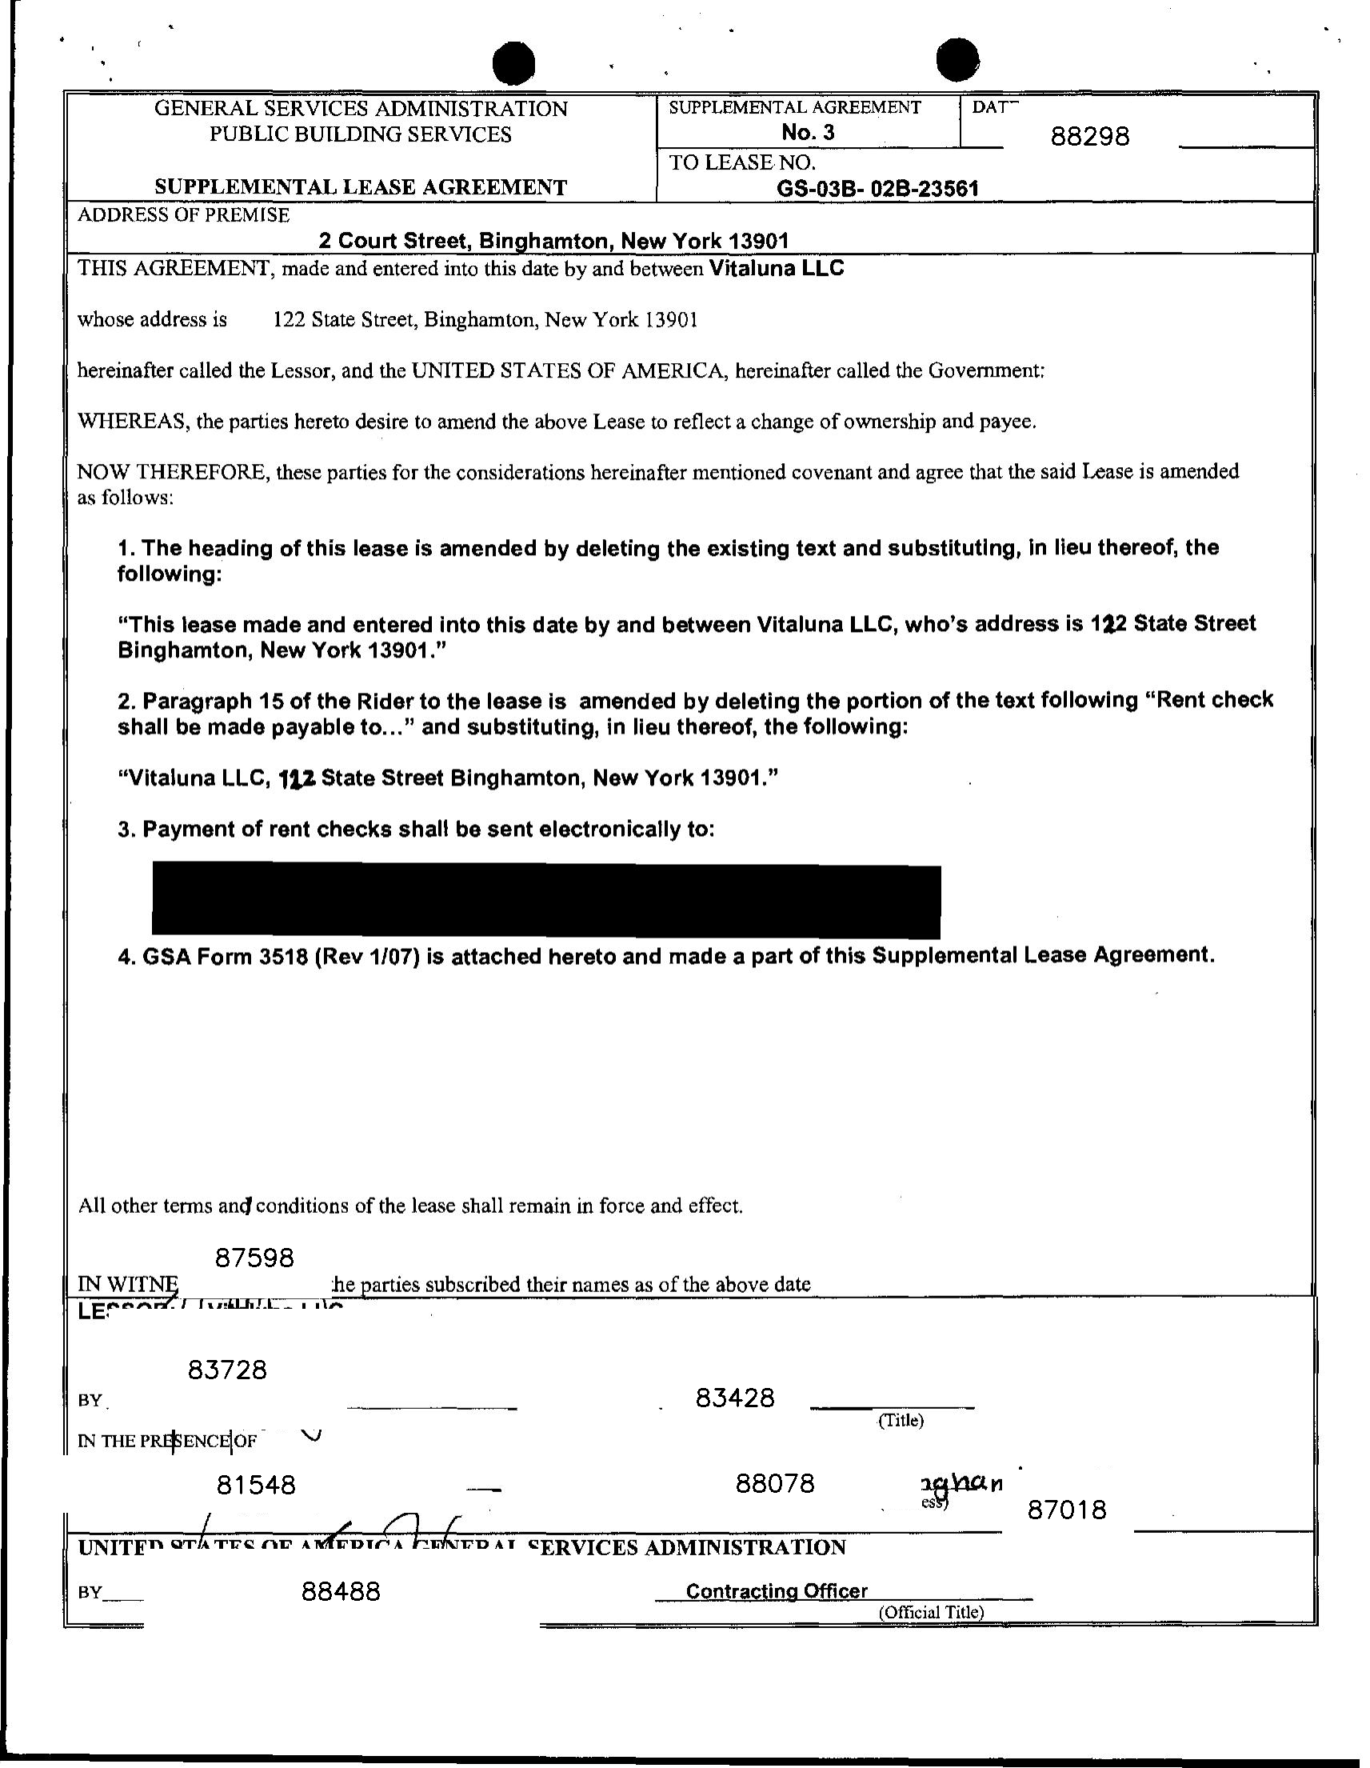

In [32]:
# save image with placeholder into local
output_placeholder = os.path.join(result_path, image_path.split('/')[-1].split('.')[0] + '_placeholder.jpg')
cv2.imwrite(output_placeholder, img)

import scipy.misc
scipy.misc.toimage(scipy.misc.imresize(img, 0.8))

In [20]:
print ('print dictionary fake text: hand-writing')
match

print dictionary fake text: hand-writing


{'81548': 'couken Chapman 1 ( signature )',
 '83428': 'Mhub',
 '83728': 'U a L ( Signature )',
 '87018': 'ton w 13901',
 '87598': 'EO',
 '88078': '12 2 State St , BIX ( Addr',
 '88298': '2',
 '88488': 'I ( Signature ) 2 th'}

## Step 8: hand-writing OCR result back to the document

In [21]:
# pass the document with machine-text placeholders to computer vision API 
polygons = pass2CV(img)
for polygon in polygons:
    print (polygon[1])

pass image to computer vision API ......
GENERAL SERVICES ADMINISTRATION
SUPPLEMENTAL AGREEMENT
PUBLIC BUILDING SERVICE
88298
TO LEASE NO
SUPPLEMENTAL LEASE AGREEMENT
GS - 038 - 028 - 23561
ADDRESS OF PREMISE
Court Street . Binghamton New York 13901
THIS AGREEMENT , made and entered into this date by and between Vitaluna LL
whose address is
122 State Street , Binghamton New York 13901
hereinafter called the Lessor , and the UNITED STATES OF AMERICA , hereinafter called the Government
WHEREAS the parties hereto desire to amend the above Lease to reflect a change of ownership and payee
NOW THEREFORE , these parties for the considerations hereinafter mentioned covenant and agree that the said I ease is amended
as follows
1 . The heading of this lease is amended by deleting the existing text and substituting , in lieu thereof the
following :
" This lease made and entered into this date by and between Vitaluna LLC , who's address is 122 State Street
Binghamton New York 13901 . "
2 . Paragra

In [22]:
# put the handwriting OCR results back to the original doc
for polygon in polygons:
    line = polygon[1]
    for key in match.keys():
        if key in polygon[1]:
            line = polygon[1].replace(key, match[key])       
    print (line)

GENERAL SERVICES ADMINISTRATION
SUPPLEMENTAL AGREEMENT
PUBLIC BUILDING SERVICE
2
TO LEASE NO
SUPPLEMENTAL LEASE AGREEMENT
GS - 038 - 028 - 23561
ADDRESS OF PREMISE
Court Street . Binghamton New York 13901
THIS AGREEMENT , made and entered into this date by and between Vitaluna LL
whose address is
122 State Street , Binghamton New York 13901
hereinafter called the Lessor , and the UNITED STATES OF AMERICA , hereinafter called the Government
WHEREAS the parties hereto desire to amend the above Lease to reflect a change of ownership and payee
NOW THEREFORE , these parties for the considerations hereinafter mentioned covenant and agree that the said I ease is amended
as follows
1 . The heading of this lease is amended by deleting the existing text and substituting , in lieu thereof the
following :
" This lease made and entered into this date by and between Vitaluna LLC , who's address is 122 State Street
Binghamton New York 13901 . "
2 . Paragraph 15 of the Rider to the lease is amended by